In [67]:
# # Install PyWake if needed
# try:
#     import py_wake
# except ModuleNotFoundError:
#     !pip install git+https://gitlab.windenergy.dtu.dk/TOPFARM/PyWake.git

## Instalação
**(topfarm é recomendado para <3.12)**

- conda create --name ENVNAME python=3.11 
- conda activate ENVNAME
- pip install py_wake
- pip install topfarm
- pip install pyproj

In [68]:
import xarray as xr #Similar ao pandas mas com melhor eficiencia para trabalhar com matrizes multidimensionais, muito bom para dados georref
import numpy as np
from scipy.stats import weibull_min
from py_wake.site.xrsite import XRSite
from py_wake.site.shear import PowerShear
import matplotlib.pyplot as plt
from py_wake.flow_map import XYGrid, YZGrid, XZGrid
from pyproj import Proj, Transformer
from py_wake.wind_turbines import WindTurbine
from py_wake.wind_turbines.power_ct_functions import PowerCtTabular
import pandas as pd
from topfarm.utils import regular_generic_layout, regular_generic_layout_gradients



## Criação dos Dados para entrada no modelo ##

In [69]:
serie_historica = "/media/wendell/Windows Backup/Eolico_serie_temporal_alturas/100m/2017_raw_100m_filled.nc"
densidade_regiao = "/media/wendell/Windows Backup/Eolico_serie_temporal_alturas/100m/densidade_100m_netcdf.nc"

dataset = xr.open_dataset(serie_historica)
den = xr.open_dataset(densidade_regiao)

In [70]:
dataset

<xarray.Dataset> Size: 3GB
Dimensions:  (time: 8760, lon: 168, lat: 135)
Coordinates:
  * time     (time) datetime64[ns] 70kB 2017-01-01 ... 2017-12-31T23:00:00
  * lon      (lon) float32 672B -38.92 -38.89 -38.86 ... -34.44 -34.41 -34.38
  * lat      (lat) float32 540B -7.415 -7.388 -7.361 ... -3.85 -3.823 -3.796
Data variables:
    wspd     (time, lat, lon) float64 2GB ...
    wdir     (time, lat, lon) float64 2GB ...
Attributes:
    CDI:          Climate Data Interface version 1.9.9rc1 (https://mpimet.mpg...
    history:      Thu Mar 03 14:24:21 2022: cdo mergetime 2017-01_100m 2017-0...
    Conventions:  CF-1.6
    NCO:          netCDF Operators version 4.9.1 (Homepage = http://nco.sf.ne...
    CDO:          Climate Data Operators version 1.9.9rc1 (https://mpimet.mpg...

In [71]:
largura = dataset['lat'].values[1] - dataset['lat'].values[0] # Calcular a largura do pixel para usar como limite para os parques

In [72]:
# Função para determinar a UTM zone based na longitude
def get_utm_zone(longitude):
    return int((longitude + 180) / 6) + 1

# Function to convert degrees to UTM coordinates using vectorized operations
def convert_to_utm_vectorized(lat_array, lon_array):
    utm_zones = np.vectorize(get_utm_zone)(lon_array)
    utm_x = np.zeros_like(lat_array)
    utm_y = np.zeros_like(lat_array)
    
    for zone in np.unique(utm_zones):
        mask = utm_zones == zone
        hemisphere = 'north' if np.mean(lat_array[mask]) >= 0 else 'south'
        proj_wgs84 = Proj('epsg:4326')  # WGS84
        proj_utm = Proj(proj='utm', zone=zone, datum='WGS84', south=hemisphere=='south')
        transformer = Transformer.from_proj(proj_wgs84, proj_utm)
        utm_x[mask], utm_y[mask] = transformer.transform(lat_array[mask], lon_array[mask])
    
    return utm_x, utm_y, hemisphere

In [73]:
#Função para definir os setores relacionados com a direção dos ventos
def custom_sector(wd):
    """
    Maps wind directions to sectors, handling the wrap-around between 345° and 15°.
    """
    sectors = np.zeros_like(wd)  # Initialize an array for sector values
    sectors[(wd >= 345) | (wd < 15)] = 0   # Sector 0 for 345-15 degrees
    sectors[(wd >= 15) & (wd < 345)] = (wd[(wd >= 15) & (wd < 345)] - 15) // 30 + 1  # Sectors 1-11
    return sectors

Até o momento só consegui gerar os parametros de Weibull para usar em um pixel e esse como um apenas um parque "UniformWeibullSite" -  Site with uniform sector-dependent Weibull distributed wind speed.

Waspgrid pode ser uma alternativa mas esse nessecita de um arquivo .grd  exportado do WAsp

In [74]:
#Selecionar os dados usando as coordenadas para selecionar a linha
dataset = dataset.sel(lat=slice(-7.415, -7.388), lon=slice(-38.92, -38.89))

#Usando Sel consegue passar o "Index = Coordenada para xarray" para selecionar o dado
den = den.sel(lat=slice(-7.415, -7.388), lon=slice(-38.92, -38.89))

#Extrair os valores de cada dado conservando as coordenadads e o timestamp
wind_speed = dataset['wspd'] # 3D DataArray [time, lat, lon]
wind_direction = dataset['wdir']  # Same shape as wind_speed
air_density = den['Band1']  # 2D DataArray [lat, lon]
date_time = dataset['time']
lati = dataset['lat']
long = dataset['lon']

In [75]:
# Function to fit Weibull distribution and return parameters
def fit_weibull(data):
    c, loc, scale = weibull_min.fit(data, floc=0)
    return scale, c  # Weibull_A, Weibull_k

# Function to fit Weibull distribution for each sector over all time slices
def fit_weibull_sectors(wind_speed_data, sector_data):
    results = []
    for sector in range(12):
        sector_data_values = wind_speed_data.where(sector_data == sector, drop=True).values.flatten()
        sector_data_values = sector_data_values[~np.isnan(sector_data_values)]  # Remove NaNs
        if len(sector_data_values) > 0:
            scale, c = fit_weibull(sector_data_values)
        else:
            scale, c = np.nan, np.nan
        results.append((scale, c))
    return results


In [76]:
# Calcula setor para as direções do vento
sectors = custom_sector(wind_direction.values)
sectors = xr.DataArray(sectors, coords=wind_direction.coords, dims=wind_direction.dims)  # Converte para DataArray

# Calcula a distribuição de Weibull para cada setor
Weibull_A_k = fit_weibull_sectors(wind_speed, sectors)

print(Weibull_A_k)

[(np.float64(5.047496174615445), np.float64(3.0409498894174165)), (np.float64(4.951255989657237), np.float64(2.063581107620001)), (np.float64(4.811635035381411), np.float64(2.0994595860208074)), (np.float64(4.9750994195899505), np.float64(2.2229708826304644)), (np.float64(5.288234011649904), np.float64(2.2370205216244035)), (np.float64(7.667684977335193), np.float64(3.024665503191133)), (np.float64(6.897832893386719), np.float64(3.435526678796057)), (np.float64(3.762528764616948), np.float64(1.316426110394726)), (np.float64(3.0713585394267984), np.float64(1.9412721759214928)), (np.float64(2.5581200671179354), np.float64(1.8856911658228892)), (np.float64(3.6856858509132255), np.float64(1.9263019946876099)), (np.float64(4.167666547462828), np.float64(2.4902322070567617))]


In [77]:
# Separa o A do K de Weibull
Weibull_A = [result[0] for result in Weibull_A_k]
Weibull_k = [result[1] for result in Weibull_A_k]

In [78]:
# Cria um novo Dataset combinando wind_speed e sectors para gerar media e desvio padrão por setor para criar a intesidade de turbulência
combined_ds = xr.Dataset(
    {
        'wind_speed': wind_speed,
        'sector': sectors
    }
)
combined_ds

<xarray.Dataset> Size: 210kB
Dimensions:     (time: 8760, lon: 1, lat: 1)
Coordinates:
  * time        (time) datetime64[ns] 70kB 2017-01-01 ... 2017-12-31T23:00:00
  * lon         (lon) float32 4B -38.92
  * lat         (lat) float32 4B -7.415
Data variables:
    wind_speed  (time, lat, lon) float64 70kB ...
    sector      (time, lat, lon) float64 70kB 5.0 5.0 5.0 6.0 ... 2.0 2.0 3.0

In [79]:
ti = [] # Turbulencia é o desvio padrao dividido pela média do vento
# Calcula a turbulência para cada setor
sec = np.unique(sectors.values)
for i in sec:
    sector_data = combined_ds.where(sectors == i, drop=True)
    u_sector = sector_data['wind_speed'].mean(dim='time')  # Média do vento no setor i
    std_sector = sector_data['wind_speed'].std(dim='time')
    ti.append(u_sector.data.item()/std_sector.data.item())
    print(f"Setor {i}: {ti[-1]}")

Setor 0.0: 2.7212060123102884
Setor 1.0: 1.952202317637892
Setor 2.0: 1.9772424172704666
Setor 3.0: 2.088775465849997
Setor 4.0: 2.1039914807734337
Setor 5.0: 2.722098727004091
Setor 6.0: 3.109147708327291
Setor 7.0: 1.356784286826237
Setor 8.0: 1.8573824884920185
Setor 9.0: 1.7949743734632673
Setor 10.0: 1.8445919513766003
Setor 11.0: 2.30355461439058


## Exemplo de padrão de informações para criação de um site com baseado em weibull ##
# Caracteristicas do vento #
f = [0.036, 0.039, 0.052, 0.07, 0.084, 0.064, 0.086, 0.118, 0.152, 0.147, 0.1, 0.052]
A = [9.177, 9.782, 9.532, 9.91, 10.043, 9.594, 9.584, 10.515, 11.399, 11.687, 11.637, 10.088]
k = [2.393, 2.447, 2.412, 2.592, 2.756, 2.596, 2.584, 2.549, 2.471, 2.607, 2.627, 2.326]
wd = [0, 30, 60, 90, 120, 150, 180, 210, 240, 270, 300, 330]#np.linspace(0, 360, len(f), endpoint=False)
ti = [2.72, 1.95, 1.98, 2.09, 2.10, 2.05, 2.01, 2.00, 1.95, 1.90, 1.85, 1.80]


In [80]:
# Calcula a frequencia de cada direção
sector_counts = sectors.to_series().value_counts().sort_index()
total_count = sector_counts.sum()
f = (sector_counts / total_count).to_list()

#Configura o  Turbulence intensity - TI, e 
#ti = 0.1 # Desvio padrão da velocidade do vento / Velocidade média do vento
#Gera o vetor de direção "referencia"
wd = np.linspace(0, 360, len(f), endpoint=False)

ds = xr.Dataset(
    data_vars={
        'Sector_frequency': ('wd', f),
        'Weibull_A': ('wd', Weibull_A),
        'Weibull_k': ('wd', Weibull_k),
        'TI': ('wd', ti)   #colocar uma lista
    },
    coords={
        'wd': wd,
    }
)

In [81]:
ds

<xarray.Dataset> Size: 480B
Dimensions:           (wd: 12)
Coordinates:
  * wd                (wd) float64 96B 0.0 30.0 60.0 90.0 ... 270.0 300.0 330.0
Data variables:
    Sector_frequency  (wd) float64 96B 0.0274 0.05719 ... 0.01324 0.02306
    Weibull_A         (wd) float64 96B 5.047 4.951 4.812 ... 2.558 3.686 4.168
    Weibull_k         (wd) float64 96B 3.041 2.064 2.099 ... 1.886 1.926 2.49
    TI                (wd) float64 96B 2.721 1.952 1.977 ... 1.795 1.845 2.304

UniformWeibullSite: Site with uniform sector-dependent Weibull distributed wind speed.

WaspGridSite: Site with gridded non-uniform inflow based on *.grd files exported from WAsP.

XRSite: The flexible general base class behind all Sites.

In [82]:
# Create an XRSite object: cria o dataset para altura de referencia da maquina utilizando lei de potencia
site = XRSite(ds=ds, shear=PowerShear(h_ref=100)) # necessário é possível alpha=.1, interp_method='nearest' que vem assim por default
# Possibilidade de criar com outro modelo de shear, por exemplo:
#site = XRSite(ds= ds, shear=LogShear(h_ref=100, z0=.15))


Se precisar salvar varios arquivos NetCDF para salvar as distribuições de Weibull para usar depois e calcular o parque de forma separada

- Salvar o site em um netCDF
site_ds = site.ds
site_ds.to_netcdf('teste_site.nc')

- Carregar o XRSite data do NetCDF
loaded_site_ds = xr.open_dataset('teste_site.nc')

- Create a new XRSite object using the loaded data
loaded_site = XRSite(ds=loaded_site_ds, shear=PowerShear(h_ref=100))

- Verify the loaded data (optional)
print(loaded_site.ds)

In [83]:
# Replace 'your_file.csv' with the path to your CSV file
csv_file_path = '/media/wendell/Windows Backup/Arquivos_wendell/NREL_5MW_126_RWT.csv'

# Read the CSV file into a DataFrame
tb = pd.read_csv(csv_file_path)

# Display the first few rows of the DataFrame
print(tb.head())

   Wind Speed [m/s]  Power [kW]    Cp [-]  Thrust [kN]    Ct [-]
0               3.0        40.5  0.196406        171.7  2.497990
1               4.0       177.7  0.363555        215.9  1.766833
2               5.0       403.9  0.423084        268.9  1.408360
3               6.0       737.6  0.447126        330.3  1.201348
4               7.0      1187.2  0.453203        398.6  1.065134


In [84]:
############################################################################################
#************Turbina NREL Exemplo de criação um objeto turbina
############################################################################################
vel_turbine = tb['Wind Speed [m/s]']
pot_turbine = tb['Power [kW]']
ct = tb['Ct [-]']

# Define the hub height of the turbine
hub_height = 110  # in meters
diameter_turb = 126  # in meters

wt_NREL = WindTurbine(name='NRel5MW',
                    diameter=diameter_turb,
                    hub_height=hub_height,
                    powerCtFunction=PowerCtTabular(vel_turbine,pot_turbine,'kW',ct))

In [85]:
############################################################################################
#************Turbina
############################################################################################
vel_turbine = np.arange(0, 23, .5)
pot_turbine = [0,0,0,0,0,0,49, 127, 224, 339, 480, 651, 857, 1099, 1382, 1705, 2067, 2460, 2849, 3174, 3369, 3434, 3449, 3450, 3450,3450,3450,3450,3450,3450,3450,3450,3450,3450,3450,3450,3450,3450,3450,3450,3450,3450,3450,3450,3450,3450]
ct = np.ones(46)*0.8

# Define the hub height of the turbine
hub_height = 100  # in meters

my_wt = WindTurbine(name='MyWT',
                    diameter=diameter_turb,
                    hub_height=hub_height,
                    powerCtFunction=PowerCtTabular(vel_turbine,pot_turbine,'kW',ct))

In [86]:
#Importes para conseguir gerar o Wake model
from py_wake.wind_farm_models import PropagateDownwind
from py_wake.deficit_models.gaussian import BastankhahGaussianDeficit
from py_wake.superposition_models import LinearSum

In [87]:
deslocamento = largura/2
x = np.arange((-5.756739 - deslocamento),
               (-5.756739 + deslocamento),
                 (largura/3))
y = np.arange((-36.007004 - deslocamento),
               (-36.007004 + deslocamento),
                 (largura/3))

#x, y = convert_to_utm_vectorized(x, y)

In [88]:
print(x, y)
import utm
# Initialize empty lists to store UTM coordinates
utm_eastings = []
utm_northings = []
utm_zone_numbers = []
utm_zone_letters = []

for lat, lon in zip(x, y):
    easting, northing, zone_number, zone_letter = utm.from_latlon(lat, lon)
    utm_eastings.append(easting)
    utm_northings.append(northing)
    utm_zone_numbers.append(zone_number)
    utm_zone_letters.append(zone_letter)

# Convert lists to NumPy arrays if needed for PyWake
x_utm = np.array(utm_eastings)
y_utm = np.array(utm_northings)

print(x_utm, y_utm)


[-5.77019358 -5.76122379 -5.75225401] [-36.02045822 -36.01148987 -36.00252151]
[830026.40952479 831025.87697113 832025.37572868] [9361335.30232345 9362322.95443872 9363310.60662559]


In [89]:
print(-5.756739 - deslocamento)
print(-36.007004 - deslocamento)
print(x, y)

-5.7701936
-36.02046
[-5.77019358 -5.76122379 -5.75225401] [-36.02045822 -36.01148987 -36.00252151]


In [90]:
def convert_to_utm_vectorized(lon_array, lat_array):
    # Ensure inputs are numpy arrays
    lat_array = np.asarray(lat_array)
    lon_array = np.asarray(lon_array)

    # Vectorized UTM zone
    get_zone_vectorized = np.vectorize(get_utm_zone)
    utm_zones = get_zone_vectorized(lon_array)

    # Prepare outputs
    utm_x = np.zeros_like(lon_array)
    utm_y = np.zeros_like(lat_array)
    hemisphere_array = np.full_like(lat_array, '', dtype=object)

    for zone in np.unique(utm_zones):
        mask = utm_zones == zone
        hemisphere = 'north' if np.mean(lat_array[mask]) >= 0 else 'south'
        proj_wgs84 = Proj('epsg:4326')
        proj_utm = Proj(proj='utm', zone=zone, datum='WGS84', south=(hemisphere == 'south'))
        transformer = Transformer.from_proj(proj_wgs84, proj_utm, always_xy=True)
        utm_x[mask], utm_y[mask] = transformer.transform(lon_array[mask], lat_array[mask])
        hemisphere_array[mask] = hemisphere

    return utm_x, utm_y, hemisphere_array


In [91]:
# x, y, hemisferio = convert_to_utm_vectorized(x, y)
# print(x, y, hemisferio)
n_wt = 3

rotor_diameter = 150
y_dist = 12*rotor_diameter # Criação do padrão de espaçamento dos aerogeradores
x_dist = 3*rotor_diameter
angulo = 30 #Angulo da disposição da grade
stagger = 1 * rotor_diameter   # Desalinhar os aerogeradores para criar a grade baseado no diametro

def reg_func(n_wt, sx, sy, stagger, rotation, **kwargs): # Função para gerar uma grade regular e generica de disposição dos aeros
    x, y = regular_generic_layout(n_wt, sx, sy, stagger, rotation)
    return [x, y]

x, y = reg_func(n_wt, x_dist, y_dist, stagger, angulo)

In [92]:
from py_wake.wind_farm_models import All2AllIterative
from py_wake.turbulence_models import CrespoHernandez, STF2017TurbulenceModel
from py_wake.superposition_models import LinearSum, CumulativeWakeSum, WeightedSum
from py_wake.deficit_models.deficit_model import WakeDeficitModel, BlockageDeficitModel
from py_wake.deficit_models import FugaDeficit, SelfSimilarityDeficit, SelfSimilarityDeficit2020 # blockage deficit


In [ ]:
# Configuração do xarray para não expandir os dados por padrão
xr.set_options(display_expand_data=False)


#wf_model = Bastankhah_PorteAgel_2014(site, my_wt, k=0.0324555)

wf_model = PropagateDownwind(site, wt_NREL,
                             wake_deficitModel=BastankhahGaussianDeficit(use_effective_ws=True),
                             superpositionModel=LinearSum())

# wf_model = All2AllIterative(site, wt_NREL,
#                              wake_deficitModel=BastankhahGaussianDeficit(use_effective_ws=False),
#                              superpositionModel=LinearSum(), blockage_deficitModel=SelfSimilarityDeficit2020(),
#                              turbulenceModel=STF2017TurbulenceModel())


# wf_model = All2AllIterative(site, wt_NREL,
#                              wake_deficitModel=BastankhahGaussianDeficit(use_effective_ws=True),
#                              superpositionModel=LinearSum(), blockage_deficitModel=SelfSimilarityDeficit2020(),
#                              turbulenceModel=STF2017TurbulenceModel())

#x = [-500., -500., -500.,    0.,    0.,    0.,  500.,  500.,  500.]
#y = [-500.,    0.,  500., -500.,    0.,  500., -500.,    0.,  500.]

#x, y =convert_to_utm_vectorized(np.array([-5.756739]), np.array([-36.007004]))
sim_res = wf_model(x, y,     # arrays com as posições dos aerogeradores
                   h=None,   # wind turbine heights (defaults to the heights defined in windTurbines)
                   wd=None,  # Wind direction, default is all direction, list or value should be passed as argument
                   ws=None,  # Wind speed, default is all speeds, list or values should be passed
                   n_cpu=None,  # Number of CPUs to use, default is all available CPUs
                  )

TypeError: PropagateDownwind.__init__() got an unexpected keyword argument 'n_cpu'

In [ ]:
#x,y = convert_to_utm_vectorized(np.array([-7.414711, -7.387802]), np.array([-38.917034, -38.889893]))
wf_model


In [ ]:
sim_res

<xarray.SimulationResult> Size: 2MB
Dimensions:           (wt: 3, wd: 360, ws: 23)
Coordinates:
  * ws                (ws) int64 184B 3 4 5 6 7 8 9 10 ... 19 20 21 22 23 24 25
  * wd                (wd) int64 3kB 0 1 2 3 4 5 6 ... 354 355 356 357 358 359
  * wt                (wt) int64 24B 0 1 2
    type              (wt) float64 24B 0.0 0.0 0.0
Data variables: (12/17)
    WS_eff            (wt, wd, ws) float64 199kB 3.029 4.038 ... 24.23 25.24
    TI_eff            (wt, wd, ws) float64 199kB 2.721 2.721 ... 2.707 2.707
    Power             (wt, wd, ws) float64 199kB 4.444e+04 1.864e+05 ... 5e+06
    CT                (wt, wd, ws) float64 199kB 2.477 1.753 ... 0.08373 0.07737
    h                 (wt, wd, ws) float64 199kB 110.0 110.0 ... 110.0 110.0
    x                 (wt, wd, ws) float64 199kB 0.0 0.0 0.0 ... -900.0 -900.0
    ...                ...
    ws_l              (ws) float64 184B 2.5 3.5 4.5 5.5 ... 21.5 22.5 23.5 24.5
    ws_u              (ws) float64 184B 3.5 4.5 5.5 6.5 ... 22.5 23.5 24.5 25.5
    Weibull_A         (wd) float64 3kB 5.047 5.044 5.041 ... 4.96 4.989 5.018
    Weibull_k         (wd) float64 3kB 3.041 3.008 2.976 ... 2.986 3.004 3.023
    Sector_frequency  (wd) float64 3kB 0.0009132 0.0009463 ... 0.0009084
    P                 (wd, ws) float64 66kB 0.000154 0.0002065 ... 0.0 0.0

In [ ]:
#Produção de energia eletrica para a turbina zero (wt=0) com o vento na direção
print(sim_res.Power.sel(wt=0))

#Potencia total da turbina 0
total_power = sim_res.Power.sel(wt=2).sum().values/1e6
print(total_power)

#AEP das turbinas de todas as velocidade e direções, aep por padrão considera efeitos de perda"sim_res.aep(with_wake_loss=False).sum().data"
print('Total power: %f GWh'%sim_res.aep().sum().values)


<xarray.DataArray 'Power' (wd: 360, ws: 23)> Size: 66kB
4.444e+04 1.864e+05 4.199e+05 7.634e+05 1.226e+06 ... 5e+06 5e+06 5e+06 5e+06
Coordinates:
  * ws       (ws) int64 184B 3 4 5 6 7 8 9 10 11 ... 17 18 19 20 21 22 23 24 25
  * wd       (wd) int64 3kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
    wt       int64 8B 0
    type     float64 8B 0.0
Attributes:
    Description:  Power [W]
30634.28169815522
Total power: 22.412300 GWh


In [ ]:
total_power = sim_res.Power.sel(wt=2, wd=100).sum().values/1e6
print('Total power: %f MW'%total_power)

Total power: 85.305314 MW


In [ ]:
sim_res

<xarray.SimulationResult> Size: 2MB
Dimensions:           (wt: 3, wd: 360, ws: 23)
Coordinates:
  * ws                (ws) int64 184B 3 4 5 6 7 8 9 10 ... 19 20 21 22 23 24 25
  * wd                (wd) int64 3kB 0 1 2 3 4 5 6 ... 354 355 356 357 358 359
  * wt                (wt) int64 24B 0 1 2
    type              (wt) float64 24B 0.0 0.0 0.0
Data variables: (12/17)
    WS_eff            (wt, wd, ws) float64 199kB 3.029 4.038 ... 24.23 25.24
    TI_eff            (wt, wd, ws) float64 199kB 2.721 2.721 ... 2.707 2.707
    Power             (wt, wd, ws) float64 199kB 4.444e+04 1.864e+05 ... 5e+06
    CT                (wt, wd, ws) float64 199kB 2.477 1.753 ... 0.08373 0.07737
    h                 (wt, wd, ws) float64 199kB 110.0 110.0 ... 110.0 110.0
    x                 (wt, wd, ws) float64 199kB 0.0 0.0 0.0 ... -900.0 -900.0
    ...                ...
    ws_l              (ws) float64 184B 2.5 3.5 4.5 5.5 ... 21.5 22.5 23.5 24.5
    ws_u              (ws) float64 184B 3.5 4.5 5.5 6.5 ... 22.5 23.5 24.5 25.5
    Weibull_A         (wd) float64 3kB 5.047 5.044 5.041 ... 4.96 4.989 5.018
    Weibull_k         (wd) float64 3kB 3.041 3.008 2.976 ... 2.986 3.004 3.023
    Sector_frequency  (wd) float64 3kB 0.0009132 0.0009463 ... 0.0009084
    P                 (wd, ws) float64 66kB 0.000154 0.0002065 ... 0.0 0.0

In [ ]:
# Define grid limits based on your region of interest
x_min, x_max = x.min() - 500, x.max() + 500
y_min, y_max = y.min() - 500, y.max() + 500
res_grid = 100  # Define the resolution of the grid
grid = XYGrid(x=np.linspace(x_min, x_max, res_grid), y=np.linspace(y_min, y_max, res_grid))
print(grid)

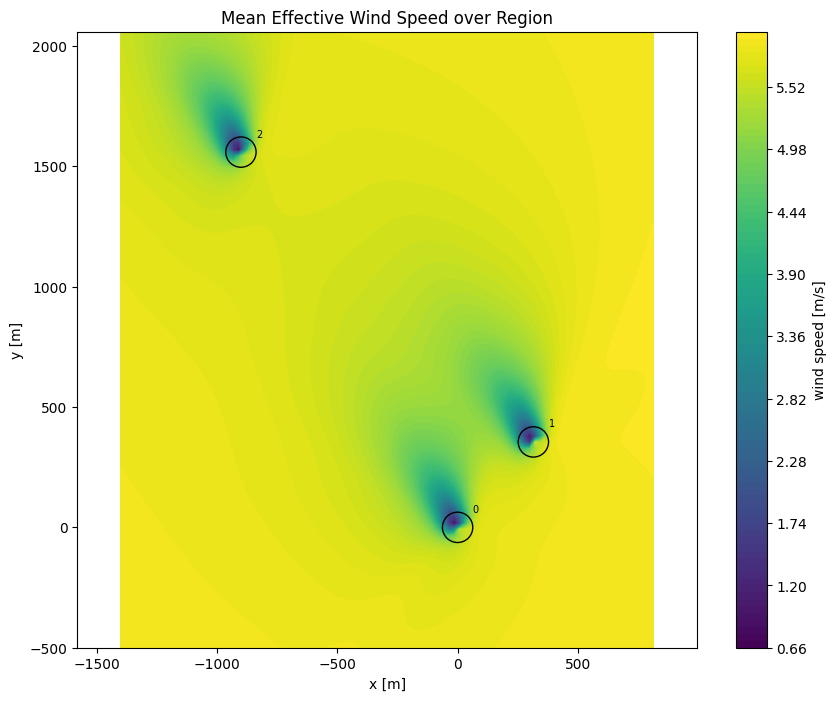

In [ ]:
flow = sim_res.flow_map(grid=grid)
plt.figure(figsize=(10, 8))
flow.plot_wake_map(cmap='viridis')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Mean Effective Wind Speed over Region')
plt.show()

In [ ]:
flow

<xarray.FlowMap> Size: 4GB
Dimensions:  (x: 100, y: 100, h: 1, wd: 360, ws: 23)
Coordinates:
  * x        (x) float64 800B -1.4e+03 -1.378e+03 -1.355e+03 ... 792.3 814.7
  * y        (y) float64 800B -500.0 -474.2 -448.3 ... 2.033e+03 2.059e+03
  * h        (h) float64 8B 110.0
  * wd       (wd) int64 3kB 0 1 2 3 4 5 6 7 ... 352 353 354 355 356 357 358 359
  * ws       (ws) int64 184B 3 4 5 6 7 8 9 10 11 ... 17 18 19 20 21 22 23 24 25
Data variables:
    WS_eff   (y, x, h, wd, ws) float64 662MB 3.029 4.038 5.048 ... 24.23 25.24
    TI_eff   (y, x, h, wd, ws) float64 662MB 2.721 2.721 2.721 ... 2.707 2.707
    WD       (y, x, h, wd, ws) int64 662MB 0 0 0 0 0 0 ... 359 359 359 359 359
    WS       (y, x, h, wd, ws) float64 662MB 3.029 4.038 5.048 ... 24.23 25.24
    TI       (y, x, h, wd, ws) float64 662MB 2.721 2.721 2.721 ... 2.707 2.707
    P        (y, x, h, wd, ws) float64 662MB 0.000154 0.0002065 ... 0.0 0.0

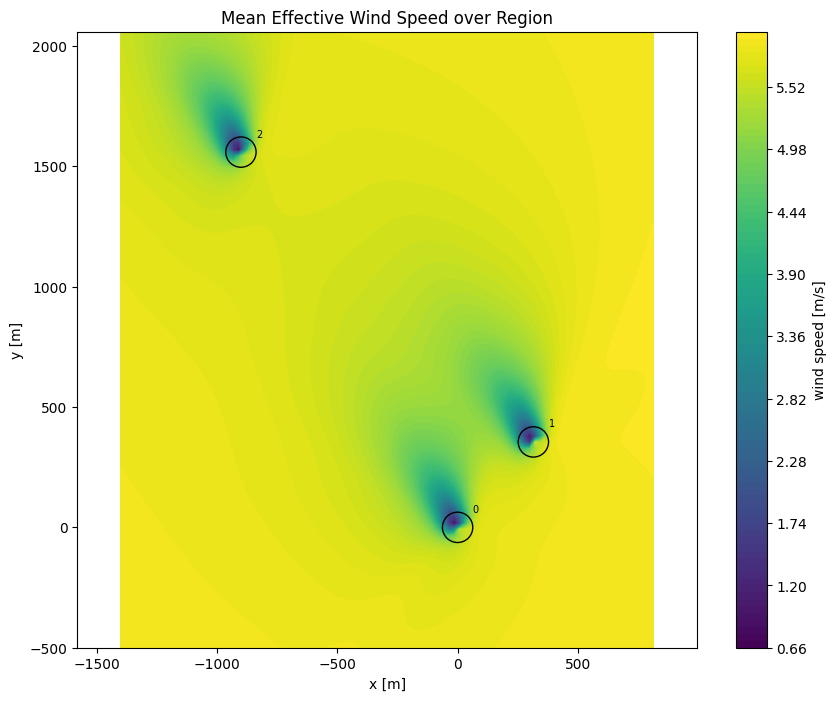

In [ ]:
# Define grid limits based on your region of interest
x_min, x_max = x.min() - 500, x.max() + 500
y_min, y_max = y.min() - 500, y.max() + 500

# Create a grid for the region
grid = XYGrid(x=np.linspace(x_min, x_max, 100), y=np.linspace(y_min, y_max, 100))

# Calculate the flow map for mean wind direction and speed (or average over all)
flow_map = sim_res.flow_map(grid=grid)

plt.figure(figsize=(10, 8))
flow_map.plot_wake_map(cmap='viridis')
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Mean Effective Wind Speed over Region')
plt.show()

In [ ]:
sim_res.groupby_bins

<bound method Dataset.groupby_bins of <xarray.SimulationResult> Size: 2MB
Dimensions:           (wt: 3, wd: 360, ws: 23)
Coordinates:
  * ws                (ws) int64 184B 3 4 5 6 7 8 9 10 ... 19 20 21 22 23 24 25
  * wd                (wd) int64 3kB 0 1 2 3 4 5 6 ... 354 355 356 357 358 359
  * wt                (wt) int64 24B 0 1 2
    type              (wt) float64 24B 0.0 0.0 0.0
Data variables: (12/17)
    WS_eff            (wt, wd, ws) float64 199kB 3.029 4.038 ... 24.23 25.24
    TI_eff            (wt, wd, ws) float64 199kB 2.721 2.721 ... 2.707 2.707
    Power             (wt, wd, ws) float64 199kB 4.444e+04 1.864e+05 ... 5e+06
    CT                (wt, wd, ws) float64 199kB 2.477 1.753 ... 0.08373 0.07737
    h                 (wt, wd, ws) float64 199kB 110.0 110.0 ... 110.0 110.0
    x                 (wt, wd, ws) float64 199kB 0.0 0.0 0.0 ... -900.0 -900.0
    ...                ...
    ws_l              (ws) float64 184B 2.5 3.5 4.5 5.5 ... 21.5 22.5 23.5 24.5
    ws_u    

Text(0.5, 1.0, 'Wake map for 150 deg and 10 m/s')

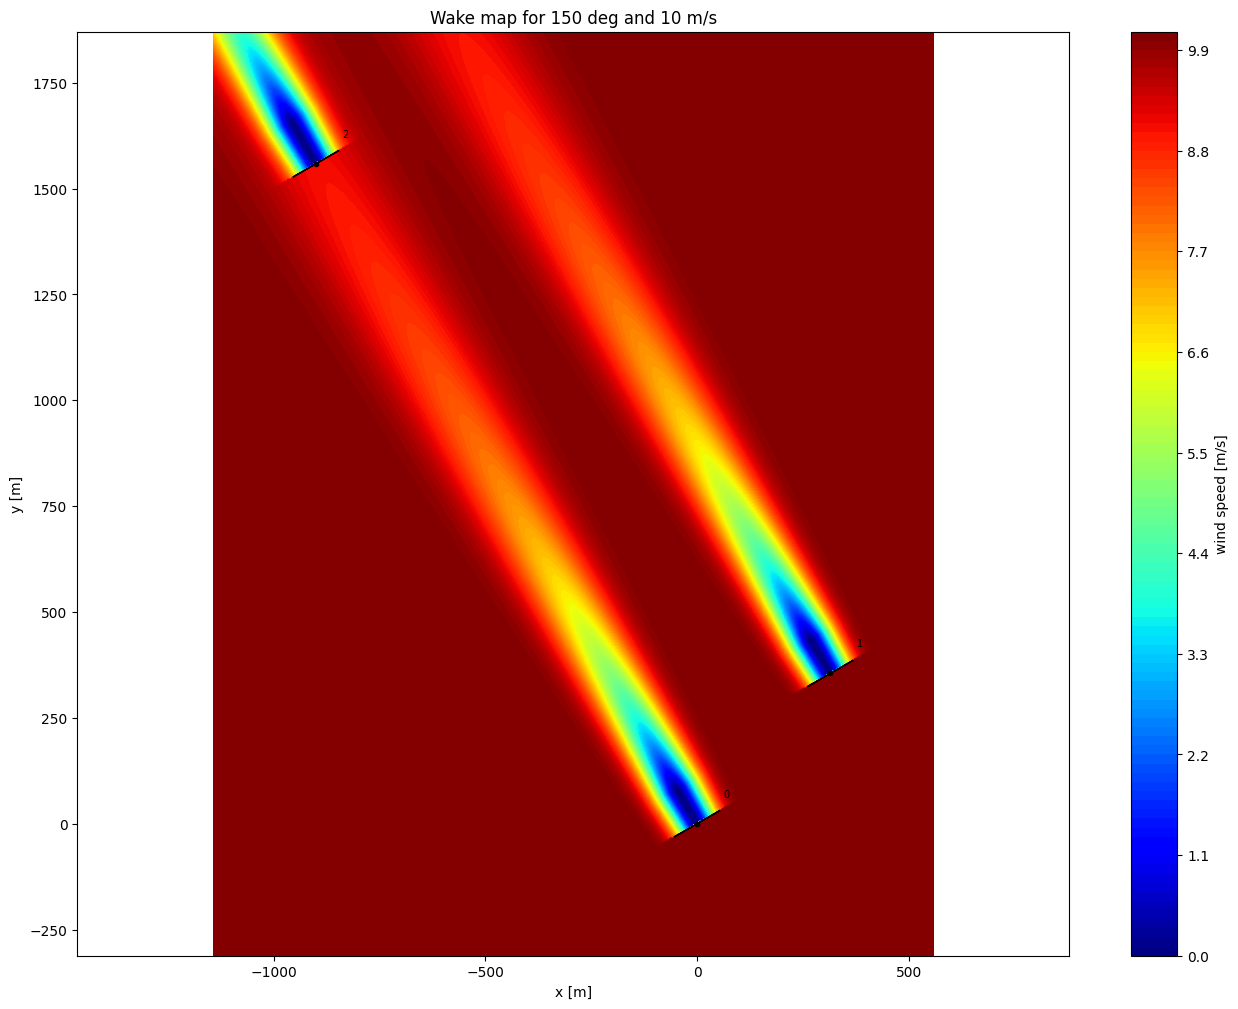

In [ ]:

plt.figure(figsize=(16, 12))
teste = wf_model(x, y, type=0, wd=150, ws=10, h=110, n_cpu=None).flow_map().plot_wake_map(cmap='jet')
# flow_map.plot_wake_map(levels=10, # contourf levels (int or list of levels)
#                        cmap='jet', # color map
#                        plot_colorbar=False,
#                        plot_windturbines=False,
#                        ax=None)
plt.xlabel('x [m]')
plt.ylabel('y [m]')
plt.title('Wake map for'+ f' {150} deg and {10} m/s')


In [ ]:
# sim_res.flow_map().to_netcdf("/home/wendell/work/output_teste_pywake.nc")

KeyboardInterrupt: 

In [ ]:
# plt.figure(figsize=(12,4))
# sim_res.flow_map(YZGrid(x=-500, y=None, resolution=1000), wd=150, ws=None).plot_wake_map(cmap='jet')
# plt.xlabel('y [m]')
# plt.ylabel('z [m]')

In [ ]:
# plt.figure(figsize=(12,4))
# sim_res.flow_map(grid=XZGrid(y=0, resolution=1000), wd=90, ws=None).plot_wake_map(cmap='jet')
# plt.xlabel('x [m]')
# plt.ylabel('z [m]')

In [ ]:
# #Import para simulação da farm com o wake model
# # Import topfarm problem, plotting support, constraint classes and generic cost model component
# from topfarm import TopFarmProblem
# from topfarm.plotting import NoPlot, XYPlotComp
# from topfarm.constraint_components.boundary import XYBoundaryConstraint, CircleBoundaryConstraint
# from topfarm.constraint_components.spacing import SpacingConstraint
# from topfarm.cost_models.cost_model_wrappers import CostModelComponent
# from topfarm.cost_models.py_wake_wrapper import PyWakeAEPCostModelComponent   #cost model
# from topfarm.easy_drivers import EasyScipyOptimizeDriver, EasySimpleGADriver
# from topfarm.examples.iea37 import get_iea37_initial, get_iea37_constraints, get_iea37_cost

In [ ]:
# x

In [ ]:
# n_wt = 3
# n_wd = 12


# cost_comp = PyWakeAEPCostModelComponent(wf_model, n_wt, wd=wd)

# #Gera as direções para simular o posicionamento
# wd = np.linspace(0.,360.,n_wd, endpoint=False)

# initial_position = {'x': x, 'y': y}

# driver = EasyScipyOptimizeDriver(maxiter=300, tol=1e-12) # o metodo utilizado para otimizar
# #driver  = EasySimpleGADriver(max_gen=300, pop_size=25, run_parallel=True)

In [ ]:
# print(x, y)
# print(initial_position)

In [ ]:
# # set up a "boundary" array with arbitrary points for use in the example
# boundary = np.array([(-1500, -1500), (-1500, 1500), (1500, -1500), (1500, 1500)])
# boundary = np.array([(-1900, 2500), (-4500, 4550), (-1000, -2500), (1500, 5000)])


# contraints_teste = XYBoundaryConstraint(boundary, 'convex_hull') #Metodo para criação do formato do boundary
# limites = [SpacingConstraint(300), contraints_teste]


In [ ]:
# #Criando os parametros para a otimização com o TopFarm
# tf_problem = TopFarmProblem(
#             initial_position,
#             cost_comp = cost_comp,
#             constraints=limites,
#             driver=driver,
#             plot_comp=XYPlotComp())

# _, state, _ = tf_problem.optimize()

# #print(state) # Posições otimizadas

In [ ]:
# #Simulação para o plot
# wf_model(state['x'], state['y'], type=0, wd=[150], ws=10, h=100, n_cpu=None).flow_map().plot_wake_map()
# plt.xlabel('x [m]')
# plt.ylabel('y [m]')
# plt.title('Wake map for'+ f' {150} deg and {10} m/s')

In [ ]:
_ = site.plot_wd_distribution(n_wd=12, ws_bins=[0,5,10,15,20,25]) #PLota a rosa dos ventos com a velocidade

In [ ]:
# #Import para usar duas funções para otimizar x,y e levar yaw
# import warnings
# warnings.filterwarnings("ignore")

# from topfarm.cost_models.cost_model_wrappers import CostModelComponent
# from topfarm import TopFarmProblem
# from topfarm.plotting import NoPlot
# from topfarm.easy_drivers import EasyScipyOptimizeDriver


In [ ]:

# #choosing the flow cases for the optimization
# wsp = np.arange(3, 13, 1)
# wdir = np.arange(100, 170, 10)

# #getting initial position of turbines
# n_wt = len(x)

# #setting up yaw angles for each turbine, wind direction and wind speed
# i = n_wt
# k = wsp.size
# l = wdir.size
# yaw_zero = np.zeros((i,l,k))  #initial condition of yaw angles


In [ ]:
# #criação da função de custo, levando em consideração x,y e yaw dos aerogeradores
# def aep_func(x, y, yaw_ilk):
#     simres = wf_model(x,y,wd=wdir,ws=wsp,yaw=yaw_ilk, tilt=0)
#     aep = simres.aep().sum()
#     return aep


In [ ]:
# #criação do modelo de custo
# cost_comp = CostModelComponent(input_keys=['x','y',('yaw_ilk', np.zeros((i, l, k)))],
#                                           n_wt = n_wt,
#                                           cost_function = aep_func,
#                                           objective=True,
#                                           maximize=True,
#                                           output_keys=[('AEP', 0)]
#                                           )


In [ ]:
# #limitador da otimização
# maxiter=300
# tol=1e-8
# ec=1e-4

# problem = TopFarmProblem(design_vars={'x': x, 'y': y, 'yaw_ilk': (yaw_zero, -30, 30)},  #setting up initial values and lower and upper bounds for yaw angles
#                           n_wt=n_wt,
#                           cost_comp=cost_comp,
#                           driver=EasyScipyOptimizeDriver(optimizer='SLSQP', maxiter=maxiter, tol=tol),
#                           plot_comp=NoPlot(),
#                           constraints=limites,
#                           expected_cost=ec)

# _, state,_ = problem.optimize()


In [ ]:
# #PLot levando em consideração a posição e o Yaw dependendo de vento e velocidade
# simulationResult = wf_model(state['x'],state['y'],wd=wdir, ws=wsp, yaw=state['yaw_ilk'][:,:,0], tilt=0)
# plt.figure(figsize=(12,6))
# simulationResult.flow_map().plot_wake_map()
# plt.xlabel('x [m]')
# plt.ylabel('y [m]')

# print(simulationResult.aep().sum().values)
# state['yaw_ilk'].shape



In [ ]:
# state['yaw_ilk']

In [ ]:
# simulationResult.flow_map()

In [ ]:
# simulationResult.flow_map().to_netcdf("/home/wendell/work/output_teste_pywake.nc")

In [ ]:
# simulationResult.aep_map()